In [2]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from models import functions

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [4]:
df = pd.read_csv('notebook/NRZ_history.csv', index_col=0)

In [5]:
df.head()

,close,volume,vwap,changeOverTime
2015-05-18,17.45,1611500.0,17.38000,0.01159
2015-05-19,17.78,2060800.0,17.70000,0.01716
2015-05-20,17.64,2145700.0,17.69000,-0.00899
2015-05-21,17.20,1205200.0,17.20000,-0.00232
2015-05-22,17.39,1476200.0,17.31667,0.01340


In [6]:
TRAIN_SPLIT = int(len(df)*0.8)

In [7]:
TRAIN_SPLIT

1007

In [8]:
# constants 
EVALUATION_INTERVAL = 200
EPOCHS = 10

BATCH_SIZE = 256
BUFFER_SIZE = 10000

In [9]:
features_considered = ['close', 'volume', 'vwap']

,close,volume,vwap
2015-05-18,17.45,1611500.0,17.38000
2015-05-19,17.78,2060800.0,17.70000
2015-05-20,17.64,2145700.0,17.69000
2015-05-21,17.20,1205200.0,17.20000
2015-05-22,17.39,1476200.0,17.31667


2015-05-18    17.45
2015-05-19    17.78
2015-05-20    17.64
2015-05-21    17.20
2015-05-22    17.39
              ...  
2020-05-11     6.31
2020-05-12     6.11
2020-05-13     5.66
2020-05-14     6.09
2020-05-15     5.91
Name: close, Length: 1259, dtype: float64


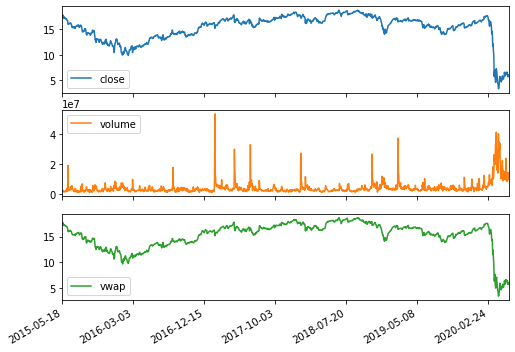

In [54]:
features = df[features_considered]
features.plot(subplots=True)
display(features.head())
print(features.iloc[:, 0])

In [55]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [12]:
dataset = (dataset-data_mean)/data_std

In [56]:
past_history = 10 # how many past days to consider
future_target = 5 # how many days to predict in the future 
STEP = 1

x_train_single, y_train_single = functions.multivariate_data(dataset, dataset[:, 0], 0, TRAIN_SPLIT, past_history, future_target, STEP, single_step=True)

x_val_single, y_val_single = functions.multivariate_data(dataset, dataset[:, 0], TRAIN_SPLIT, None, past_history, future_target, STEP, single_step=True)

In [57]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))
print ('\n Target price to predict : {}'.format(y_train_single[0].shape))

Single window of past history : (10, 3)

 Target price to predict : ()


In [58]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [59]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [60]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

(237, 1)


In [61]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 4s 21ms/step - loss: 14.3859 - val_loss: 11.9838
Epoch 2/10
200/200 [==============================] - 2s 10ms/step - loss: 13.1264 - val_loss: 10.7268
Epoch 3/10
200/200 [==============================] - 2s 10ms/step - loss: 11.8702 - val_loss: 9.4896
Epoch 4/10
200/200 [==============================] - 2s 10ms/step - loss: 10.6125 - val_loss: 8.3392
Epoch 5/10
200/200 [==============================] - 2s 10ms/step - loss: 9.3554 - val_loss: 7.4120
Epoch 6/10
200/200 [==============================] - 2s 10ms/step - loss: 8.0988 - val_loss: 6.5952
Epoch 7/10
200/200 [==============================] - 2s 10ms/step - loss: 6.8420 - val_loss: 5.7837
Epoch 8/10
200/200 [==============================] - 2s 10ms/step - loss: 5.5886 - val_loss: 4.9802
Epoch 9/10
200/200 [==============================] - 2s 10ms/step - loss: 4.3815 - val_loss: 4.1969
Epoch 10/10
200/200 [=====================

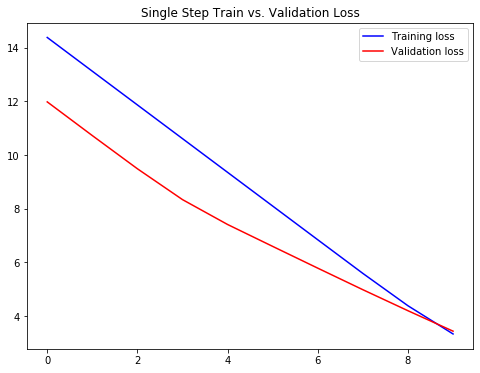

In [64]:
functions.plot_train_history(single_step_history, 'Single Step Train vs. Validation Loss')

[array([16.62, 16.53, 16.6 , 16.59, 16.52, 16.52, 16.4 , 15.98, 15.59,
       15.25]), 15.32, array([13.105136], dtype=float32)]


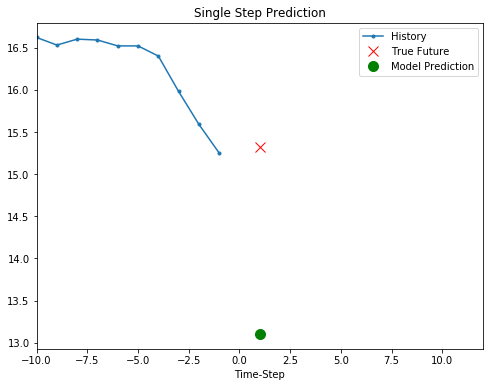

[array([16.62, 16.53, 16.6 , 16.59, 16.52, 16.52, 16.4 , 15.98, 15.59,
       15.25]), 15.32, array([13.105136], dtype=float32)]


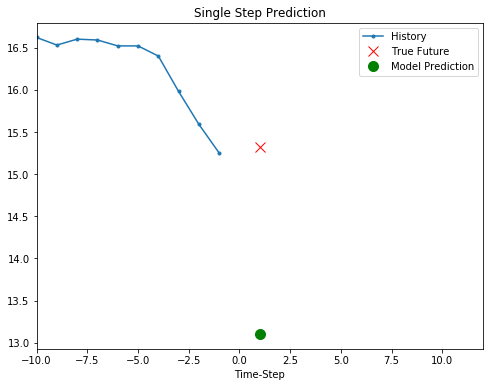

[array([16.62, 16.53, 16.6 , 16.59, 16.52, 16.52, 16.4 , 15.98, 15.59,
       15.25]), 15.32, array([13.105136], dtype=float32)]


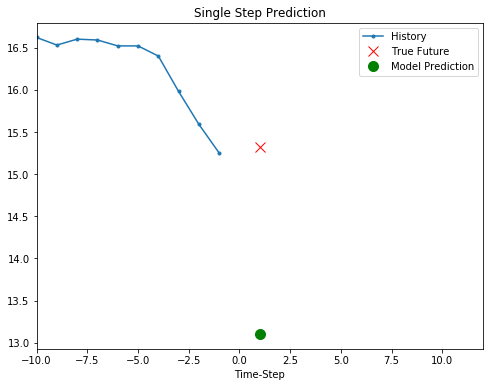

In [73]:
for x, y in val_data_single.(3):
    print([x[0][:, 0].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]])
    plot = functions.show_plot([x[0][:, 0].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 1,
                   'Single Step Prediction')
    plot.show()